**1. Данные**

In [ ]:
!pip install gdown

In [ ]:
!gdown "https://drive.google.com/file/d/1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO/view?usp=sharing" --fuzzy -O handout.tar.gz

Downloading...
From (original): https://drive.google.com/uc?id=1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO
From (redirected): https://drive.google.com/uc?id=1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO&confirm=t&uuid=27b3d0db-b95e-49af-8171-23e302d16605
To: /content/handout.tar.gz
100% 884M/884M [00:14<00:00, 59.6MB/s]


In [ ]:
!mkdir -p data
!tar -xzf handout.tar.gz

In [ ]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 237 ms, sys: 460 ms, total: 697 ms
Wall time: 720 ms


In [ ]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


In [ ]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [ ]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for img_captions in captions:
  for caption in img_captions:
    for word in caption:
      word_counts[word] += 1

In [ ]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [ ]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [ ]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

**2. Построение нейронной сети**

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()

        # a layer that converts conv features to initial LSTM state
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # create embedding for input words
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size, padding_idx=pad_ix)

        # lstm: recurrent core
        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=lstm_units,
            batch_first=True
        )

        # linear layer to map LSTM hidden states to logits over vocabulary
        self.logits = nn.Linear(lstm_units, n_tokens)

    def forward(self, image_vectors, captions_ix):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)  # [batch, lstm_units]
        initial_hid = self.cnn_to_h0(image_vectors)   # [batch, lstm_units]

        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)  # [batch, seq_len, emb_size]

        # initialize LSTM hidden and cell states
        # nn.LSTM expects (num_layers, batch, hidden_size), so we add a dimension
        h0 = initial_hid.unsqueeze(0)  # [1, batch, lstm_units]
        c0 = initial_cell.unsqueeze(0)  # [1, batch, lstm_units]

        # apply LSTM
        lstm_out, _ = self.lstm(captions_emb, (h0, c0))  # [batch, seq_len, lstm_units]

        # compute logits from lstm_out
        logits = self.logits(lstm_out)  # [batch, seq_len, n_tokens]

        return logits

In [ ]:
network = CaptionNet(n_tokens)

In [ ]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logis = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logis.shape)
assert dummy_logis.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [ ]:
def compute_loss(network, image_vectors, caption_ix):
  caption_ix_inp = caption_ix[:, :-1].contiguous()
  caption_ix_next = caption_ix[:, 1:].contiguous()

  logits_for_next = network.forward(image_vectors, caption_ix_inp)

  loss_fn = nn.CrossEntropyLoss(ignore_index=pad_ix)

  batch_size, seq_len, n_tokens = logits_for_next.shape
  logits_flat = logits_for_next.reshape(-1, n_tokens)
  targets_flat = caption_ix_next.reshape(-1)

  loss = loss_fn(logits_flat, targets_flat).unsqueeze(0)

  return loss


In [ ]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

In [ ]:
optimizer = torch.optim.Adam(
    network.parameters(),
    lr=3e-4,
    weight_decay=1e-5
)

**3. Обучение**

In [ ]:
from sklearn.model_selection import train_test_split

train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions, test_size=0.1, random_state=42)

In [ ]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

  random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

  batch_images = img_codes[random_image_ix]

  captions_for_batch_images = [captions[i] for i in random_image_ix]

  batch_captions = list(map(choice, captions_for_batch_images))

  batch_captions_ix = as_matrix(batch_captions, max_len=max_caption_len)

  return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)

In [ ]:
generate_batch(img_codes, captions, 3)

(tensor([[0.7549, 0.1454, 0.9889,  ..., 0.1164, 0.5570, 0.0789],
         [0.2852, 0.0843, 0.8412,  ..., 0.6863, 0.8560, 0.1372],
         [0.1309, 0.6475, 1.1555,  ..., 0.2549, 0.5946, 0.5668]]),
 tensor([[   1,   24,  262,  412,   31,   24,   97,   51,   24,  746, 1015,   12,
             2,    3],
         [   1,   24,   48,  140,   50,   45, 1758,   53,  248,    2,    3,    3,
             3,    3],
         [   1, 1210,   13,   14,  932,   14,  434,   15,  986,   35,   45,   71,
            12,    2]]))

In [ ]:
batch_size = 50
n_epochs = 100
n_batches_per_epoch = 50
n_validation_batches = 5

In [ ]:
from tqdm import tqdm

for epoch in range(n_epochs):

    train_loss = 0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):

        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))

        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()      # обнуляем градиенты с прошлой итерации
        loss_t.backward()          # вычисляем градиенты
        optimizer.step()           # обновляем веса

        train_loss += loss_t.item()

    train_loss /= n_batches_per_epoch

    val_loss = 0
    network.train(False)
    for _ in range(n_validation_batches):
        with torch.no_grad():  # отключаем вычисление градиентов для валидации (экономия памяти и скорости)
            loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
            val_loss += loss_t.item()
    val_loss /= n_validation_batches

    print('\nEpoch: {}, train loss: {:.4f}, val loss: {:.4f}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 50/50 [00:19<00:00,  2.62it/s]



Epoch: 0, train loss: 7.4424, val loss: 5.3234


100%|██████████| 50/50 [00:16<00:00,  3.02it/s]



Epoch: 1, train loss: 5.1080, val loss: 4.9010


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]



Epoch: 2, train loss: 4.9286, val loss: 4.9011


100%|██████████| 50/50 [00:18<00:00,  2.74it/s]



Epoch: 3, train loss: 4.7765, val loss: 4.7436


100%|██████████| 50/50 [00:19<00:00,  2.59it/s]



Epoch: 4, train loss: 4.6658, val loss: 4.5648


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]



Epoch: 5, train loss: 4.5411, val loss: 4.4981


100%|██████████| 50/50 [00:17<00:00,  2.86it/s]



Epoch: 6, train loss: 4.4635, val loss: 4.3962


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]



Epoch: 7, train loss: 4.4262, val loss: 4.3163


100%|██████████| 50/50 [00:19<00:00,  2.54it/s]



Epoch: 8, train loss: 4.3673, val loss: 4.3347


100%|██████████| 50/50 [00:20<00:00,  2.46it/s]



Epoch: 9, train loss: 4.2506, val loss: 4.2560


100%|██████████| 50/50 [00:17<00:00,  2.83it/s]



Epoch: 10, train loss: 4.2212, val loss: 4.2550


100%|██████████| 50/50 [00:17<00:00,  2.80it/s]



Epoch: 11, train loss: 4.1723, val loss: 4.1968


100%|██████████| 50/50 [00:20<00:00,  2.45it/s]



Epoch: 12, train loss: 4.1377, val loss: 4.0969


100%|██████████| 50/50 [00:18<00:00,  2.72it/s]



Epoch: 13, train loss: 4.0806, val loss: 4.0665


100%|██████████| 50/50 [00:20<00:00,  2.50it/s]



Epoch: 14, train loss: 4.0655, val loss: 3.9940


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



Epoch: 15, train loss: 3.9918, val loss: 3.9821


100%|██████████| 50/50 [00:17<00:00,  2.82it/s]



Epoch: 16, train loss: 3.9308, val loss: 3.9782


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]



Epoch: 17, train loss: 3.9191, val loss: 3.8864


100%|██████████| 50/50 [00:18<00:00,  2.76it/s]



Epoch: 18, train loss: 3.9048, val loss: 3.9363


100%|██████████| 50/50 [00:17<00:00,  2.87it/s]



Epoch: 19, train loss: 3.8643, val loss: 3.8582


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



Epoch: 20, train loss: 3.8050, val loss: 3.8145


100%|██████████| 50/50 [00:18<00:00,  2.73it/s]



Epoch: 21, train loss: 3.7901, val loss: 3.7576


100%|██████████| 50/50 [00:17<00:00,  2.82it/s]



Epoch: 22, train loss: 3.7568, val loss: 3.6585


100%|██████████| 50/50 [00:18<00:00,  2.71it/s]



Epoch: 23, train loss: 3.7091, val loss: 3.6798


100%|██████████| 50/50 [00:18<00:00,  2.70it/s]



Epoch: 24, train loss: 3.7274, val loss: 3.7160


100%|██████████| 50/50 [00:19<00:00,  2.51it/s]



Epoch: 25, train loss: 3.6971, val loss: 3.6708


100%|██████████| 50/50 [00:18<00:00,  2.66it/s]



Epoch: 26, train loss: 3.6170, val loss: 3.6894


100%|██████████| 50/50 [00:18<00:00,  2.66it/s]



Epoch: 27, train loss: 3.6160, val loss: 3.6205


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]



Epoch: 28, train loss: 3.5860, val loss: 3.6516


100%|██████████| 50/50 [00:18<00:00,  2.70it/s]



Epoch: 29, train loss: 3.5803, val loss: 3.6360


100%|██████████| 50/50 [00:19<00:00,  2.61it/s]



Epoch: 30, train loss: 3.5658, val loss: 3.5522


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]



Epoch: 31, train loss: 3.5249, val loss: 3.5549


100%|██████████| 50/50 [00:18<00:00,  2.65it/s]



Epoch: 32, train loss: 3.4643, val loss: 3.4125


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]



Epoch: 33, train loss: 3.4510, val loss: 3.3430


100%|██████████| 50/50 [00:18<00:00,  2.78it/s]



Epoch: 34, train loss: 3.4565, val loss: 3.5113


100%|██████████| 50/50 [00:17<00:00,  2.79it/s]



Epoch: 35, train loss: 3.4013, val loss: 3.3814


100%|██████████| 50/50 [00:18<00:00,  2.72it/s]



Epoch: 36, train loss: 3.4326, val loss: 3.4050


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]



Epoch: 37, train loss: 3.3999, val loss: 3.4434


100%|██████████| 50/50 [00:18<00:00,  2.74it/s]



Epoch: 38, train loss: 3.4115, val loss: 3.2929


100%|██████████| 50/50 [00:17<00:00,  2.83it/s]



Epoch: 39, train loss: 3.3303, val loss: 3.3641


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]



Epoch: 40, train loss: 3.3408, val loss: 3.3555


100%|██████████| 50/50 [00:18<00:00,  2.71it/s]



Epoch: 41, train loss: 3.3213, val loss: 3.3314


100%|██████████| 50/50 [00:18<00:00,  2.69it/s]



Epoch: 42, train loss: 3.2956, val loss: 3.4667


100%|██████████| 50/50 [00:18<00:00,  2.67it/s]



Epoch: 43, train loss: 3.3186, val loss: 3.2757


100%|██████████| 50/50 [00:19<00:00,  2.60it/s]



Epoch: 44, train loss: 3.3069, val loss: 3.3492


100%|██████████| 50/50 [00:19<00:00,  2.53it/s]



Epoch: 45, train loss: 3.2810, val loss: 3.1105


100%|██████████| 50/50 [00:17<00:00,  2.86it/s]



Epoch: 46, train loss: 3.2805, val loss: 3.2337


100%|██████████| 50/50 [00:18<00:00,  2.76it/s]



Epoch: 47, train loss: 3.2557, val loss: 3.2140


100%|██████████| 50/50 [00:19<00:00,  2.63it/s]



Epoch: 48, train loss: 3.2520, val loss: 3.2032


100%|██████████| 50/50 [00:18<00:00,  2.73it/s]



Epoch: 49, train loss: 3.2454, val loss: 3.0964


100%|██████████| 50/50 [00:18<00:00,  2.67it/s]



Epoch: 50, train loss: 3.2065, val loss: 3.2075


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]



Epoch: 51, train loss: 3.2163, val loss: 3.3223


100%|██████████| 50/50 [00:18<00:00,  2.64it/s]



Epoch: 52, train loss: 3.2085, val loss: 3.2103


100%|██████████| 50/50 [00:19<00:00,  2.61it/s]



Epoch: 53, train loss: 3.2089, val loss: 3.2521


100%|██████████| 50/50 [00:18<00:00,  2.76it/s]



Epoch: 54, train loss: 3.1998, val loss: 3.1464


100%|██████████| 50/50 [00:19<00:00,  2.53it/s]



Epoch: 55, train loss: 3.2033, val loss: 3.1886


100%|██████████| 50/50 [00:18<00:00,  2.71it/s]



Epoch: 56, train loss: 3.1703, val loss: 3.1541


100%|██████████| 50/50 [00:20<00:00,  2.50it/s]



Epoch: 57, train loss: 3.1686, val loss: 3.2590


100%|██████████| 50/50 [00:19<00:00,  2.62it/s]



Epoch: 58, train loss: 3.1755, val loss: 3.1221


100%|██████████| 50/50 [00:19<00:00,  2.61it/s]



Epoch: 59, train loss: 3.1520, val loss: 3.0655


100%|██████████| 50/50 [00:18<00:00,  2.64it/s]



Epoch: 60, train loss: 3.0775, val loss: 3.2806


100%|██████████| 50/50 [00:18<00:00,  2.70it/s]



Epoch: 61, train loss: 3.0905, val loss: 3.1772


100%|██████████| 50/50 [00:18<00:00,  2.65it/s]



Epoch: 62, train loss: 3.1208, val loss: 3.0265


100%|██████████| 50/50 [00:17<00:00,  2.81it/s]



Epoch: 63, train loss: 3.0916, val loss: 3.2512


100%|██████████| 50/50 [00:18<00:00,  2.71it/s]



Epoch: 64, train loss: 3.0875, val loss: 3.1596


100%|██████████| 50/50 [00:19<00:00,  2.63it/s]



Epoch: 65, train loss: 3.0814, val loss: 2.9401


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]



Epoch: 66, train loss: 3.0662, val loss: 2.9942


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]



Epoch: 67, train loss: 3.0761, val loss: 3.0143


100%|██████████| 50/50 [00:18<00:00,  2.67it/s]



Epoch: 68, train loss: 3.0627, val loss: 3.0212


100%|██████████| 50/50 [00:18<00:00,  2.77it/s]



Epoch: 69, train loss: 3.0660, val loss: 3.0232


100%|██████████| 50/50 [00:17<00:00,  2.81it/s]



Epoch: 70, train loss: 3.0540, val loss: 3.0364


100%|██████████| 50/50 [00:18<00:00,  2.66it/s]



Epoch: 71, train loss: 3.0588, val loss: 3.0359


100%|██████████| 50/50 [00:19<00:00,  2.50it/s]



Epoch: 72, train loss: 3.0284, val loss: 2.9078


100%|██████████| 50/50 [00:18<00:00,  2.70it/s]



Epoch: 73, train loss: 3.0172, val loss: 3.0521


100%|██████████| 50/50 [00:19<00:00,  2.54it/s]



Epoch: 74, train loss: 3.0604, val loss: 3.2072


100%|██████████| 50/50 [00:18<00:00,  2.70it/s]



Epoch: 75, train loss: 3.0410, val loss: 3.1321


100%|██████████| 50/50 [00:18<00:00,  2.66it/s]



Epoch: 76, train loss: 2.9979, val loss: 3.0114


100%|██████████| 50/50 [00:18<00:00,  2.67it/s]



Epoch: 77, train loss: 2.9870, val loss: 3.0064


100%|██████████| 50/50 [00:17<00:00,  2.78it/s]



Epoch: 78, train loss: 3.0134, val loss: 2.9196


100%|██████████| 50/50 [00:18<00:00,  2.73it/s]



Epoch: 79, train loss: 2.9872, val loss: 3.0609


100%|██████████| 50/50 [00:17<00:00,  2.83it/s]



Epoch: 80, train loss: 2.9778, val loss: 3.0924


100%|██████████| 50/50 [00:17<00:00,  2.81it/s]



Epoch: 81, train loss: 2.9926, val loss: 3.1456


100%|██████████| 50/50 [00:19<00:00,  2.60it/s]



Epoch: 82, train loss: 2.9560, val loss: 2.9248


100%|██████████| 50/50 [00:17<00:00,  2.94it/s]



Epoch: 83, train loss: 2.9971, val loss: 3.0420


100%|██████████| 50/50 [00:19<00:00,  2.62it/s]



Epoch: 84, train loss: 2.9729, val loss: 2.9732


100%|██████████| 50/50 [00:18<00:00,  2.71it/s]



Epoch: 85, train loss: 2.9388, val loss: 3.0065


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]



Epoch: 86, train loss: 2.9741, val loss: 3.0088


100%|██████████| 50/50 [00:18<00:00,  2.65it/s]



Epoch: 87, train loss: 2.9406, val loss: 3.0050


100%|██████████| 50/50 [00:16<00:00,  2.94it/s]



Epoch: 88, train loss: 2.9242, val loss: 2.9825


100%|██████████| 50/50 [00:18<00:00,  2.77it/s]



Epoch: 89, train loss: 2.9756, val loss: 2.9632


100%|██████████| 50/50 [00:19<00:00,  2.54it/s]



Epoch: 90, train loss: 2.9379, val loss: 2.8267


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]



Epoch: 91, train loss: 2.9139, val loss: 2.8555


100%|██████████| 50/50 [00:16<00:00,  3.02it/s]



Epoch: 92, train loss: 2.9254, val loss: 2.8147


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



Epoch: 93, train loss: 2.9272, val loss: 3.0173


100%|██████████| 50/50 [00:16<00:00,  3.05it/s]



Epoch: 94, train loss: 2.9252, val loss: 2.9547


100%|██████████| 50/50 [00:17<00:00,  2.88it/s]



Epoch: 95, train loss: 2.9656, val loss: 2.9426


100%|██████████| 50/50 [00:18<00:00,  2.76it/s]



Epoch: 96, train loss: 2.9345, val loss: 3.0522


100%|██████████| 50/50 [00:17<00:00,  2.83it/s]



Epoch: 97, train loss: 2.9055, val loss: 2.8871


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]



Epoch: 98, train loss: 2.8885, val loss: 2.8039


100%|██████████| 50/50 [00:18<00:00,  2.64it/s]



Epoch: 99, train loss: 2.8622, val loss: 2.9397
Finished!


**4. Применяем обученную модель**

In [31]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


100%|██████████| 104M/104M [00:00<00:00, 194MB/s] 


Генерируем подписи

In [32]:
def generate_caption(image, caption_prefix=("#START#",),
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break

    return caption_prefix

In [33]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as numpy
%matplotlib inline

# Скачиваем изображение
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg

# Загружаем и изменяем размер
img_pil = Image.open('data/img.jpg').convert('RGB')
img_resized = img_pil.resize((299, 299))  # (width, height)
img = np.array(img_resized).astype('float32') / 255.0

--2025-11-23 19:46:31--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2025-11-23 19:46:32--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pyxis.nymag.com (pyxis.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.006s  

2025-11-23 19:46:32 (8.92 MB/s) - ‘data/img.jpg’ saved [54731/547

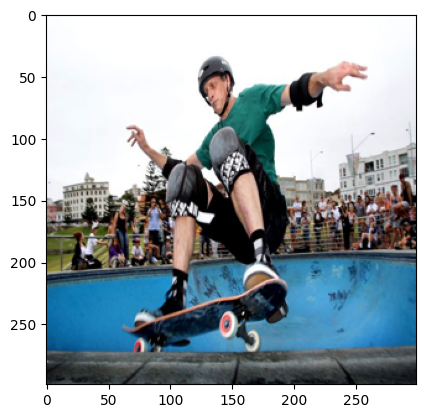

In [34]:
plt.imshow(img)

In [35]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard on a skateboard .
a man is doing a trick on a skateboard .
a man is riding a skateboard on a skateboard .
a man is riding a skateboard on a skateboard .
a man is riding a skateboard down a ramp .
a man riding a skateboard on a skateboard .
a man is riding a skateboard on a skateboard .
a man is riding a skateboard on a skateboard .
a man in a skateboard is doing a trick .
a man is doing a trick on a skateboard .


In [37]:
img_pil = Image.open('banks.jpg').convert('RGB')
img_resized = img_pil.resize((299, 299))  # (width, height)
img = np.array(img_resized).astype('float32') / 255.0

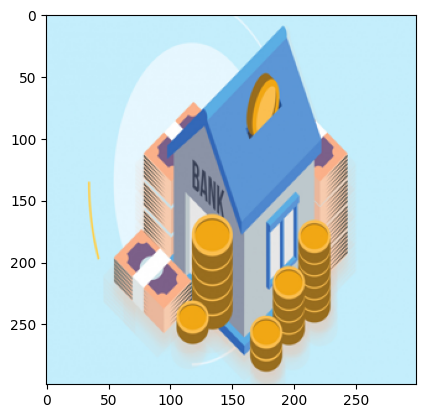

In [38]:
plt.imshow(img)

In [39]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a white and white clock on a wooden table .
a large green and white bowl of a small clock .
a large white and white clock on a table .
a small white and white photo of a large clock on a table .
a large green and white clock on a table .
a large white and white clock on a wooden table .
a small white plate with a clock on it .
a small white plate with a clock on it .
a large green and white clock on a wall .
a small white plate with a clock on it .


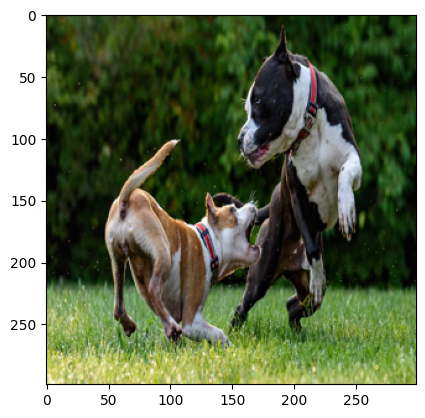

In [42]:
img_pil = Image.open('dogs.jpg').convert('RGB')
img_resized = img_pil.resize((299, 299))  # (width, height)
img = np.array(img_resized).astype('float32') / 255.0

plt.imshow(img)

In [43]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a dog is standing in the grass with a frisbee .
a dog is standing in a field with a frisbee .
a dog is standing in a field with a frisbee in the background .
a dog is standing in the grass with a frisbee .
a dog is standing next to a frisbee in a field .
a dog is standing in a field with a frisbee in the background .
a dog is standing in the grass next to a frisbee .
a dog is standing in the grass with a frisbee .
a dog is standing on a field with a frisbee in the background .
a dog is standing in a field with a frisbee .


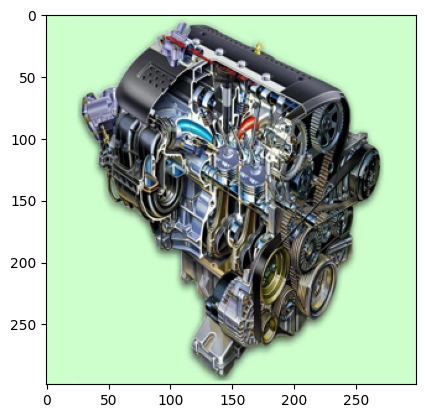

In [44]:
img_pil = Image.open('dvs.jpg').convert('RGB')
img_resized = img_pil.resize((299, 299))  # (width, height)
img = np.array(img_resized).astype('float32') / 255.0

plt.imshow(img)

In [45]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man is riding a skateboard down a street .
a man is riding a skateboard in the back of a motorcycle .
a man is standing on a branch with a dog .
a man is standing in a green field .
a man is riding on a skateboard in a parking lot .
a man is standing on a wooden bench .
a man is riding a skateboard down a street .
a man in a suit and a suit and a man in a suit
a man is riding a skateboard in the back of a motorcycle .
a man is standing on a street with a bunch of scissors .


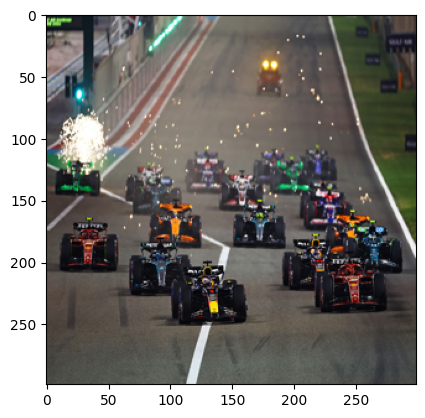

In [47]:
img_pil = Image.open('f1.jpeg').convert('RGB')
img_resized = img_pil.resize((299, 299))  # (width, height)
img = np.array(img_resized).astype('float32') / 255.0

plt.imshow(img)

In [48]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a group of people are parked on a street .
a group of people on a beach with umbrellas in the background .
a group of people are on the beach with a large umbrella .
a group of people on a beach with a large kite .
a group of people are standing on a beach .
a group of people are standing on a beach .
a group of people riding a street with a large city street .
a group of people walking down a street with a city street .
a group of people on a beach with a large umbrella .
a group of people riding a street with a large city street .


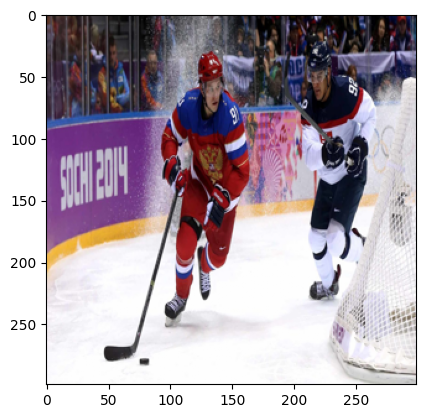

In [49]:
img_pil = Image.open('hockey.jpg').convert('RGB')
img_resized = img_pil.resize((299, 299))  # (width, height)
img = np.array(img_resized).astype('float32') / 255.0

plt.imshow(img)

In [50]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man in a blue shirt is riding a snowboard .
a man in a white shirt is riding a skateboard .
a man is riding a skateboard down the side of a road .
a man riding a skateboard down a hill .
a man on a snowboard in a snow covered slope .
a man riding a skateboard down a hill .
a man is riding a skateboard down a street .
a man in a snow jacket is skiing down a snowy hill .
a man is riding a skateboard down a mountain .
a man is riding a snowboard on a snowy hill .


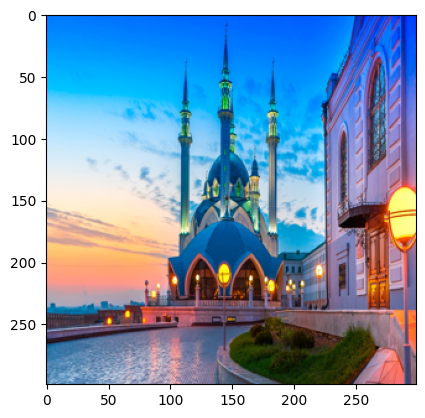

In [51]:
img_pil = Image.open('kazan.jpg').convert('RGB')
img_resized = img_pil.resize((299, 299))  # (width, height)
img = np.array(img_resized).astype('float32') / 255.0

plt.imshow(img)

In [52]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a large building with a clock on the side of it .
a large clock tower with a clock on the side of it .
a large clock tower with a clock on it .
a large clock tower with a large clock in the background .
a large clock tower with a large clock on the side .
a large clock tower with a clock on it .
a large building with a clock on the side of it .
a large building with a clock on the side of it .
a large building with a clock on it .
a large clock tower with a large clock on it .


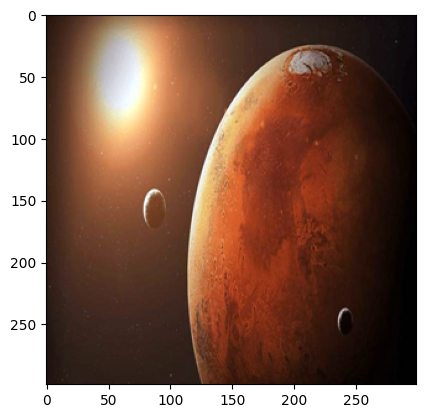

In [53]:
img_pil = Image.open('mars.jpg').convert('RGB')
img_resized = img_pil.resize((299, 299))  # (width, height)
img = np.array(img_resized).astype('float32') / 255.0

plt.imshow(img)

In [54]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a large white plate with a clock on it
a man is holding a large board in the air .
a large white and white photo of a white and white clock
a large white and white photo of a white and white clock .
a large white and white photo of a large clock on a street .
a large white photo of a large building with a clock on it .
a white and white photo of a small white clock on a street .
a white and white photo of a large clock on the side of a street .
a large white plate with a clock on it
a large white plate with a clock on it .


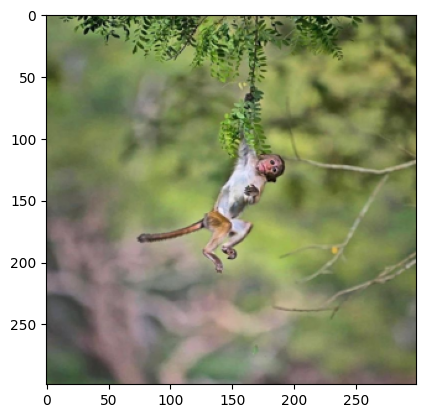

In [55]:
img_pil = Image.open('monkey.jpg').convert('RGB')
img_resized = img_pil.resize((299, 299))  # (width, height)
img = np.array(img_resized).astype('float32') / 255.0

plt.imshow(img)

In [56]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man is standing on a bench in the grass .
a man is standing on a bench in the grass .
a man is standing on a bench in the grass .
a man is standing on a field with a frisbee .
a man is standing on a wooden bench .
a man is sitting on a bench in the grass .
a man is standing in the grass with a frisbee .
a man is standing on a bench in the grass .
a man is standing on a bench in the grass .
a man is standing on a bench in the grass .


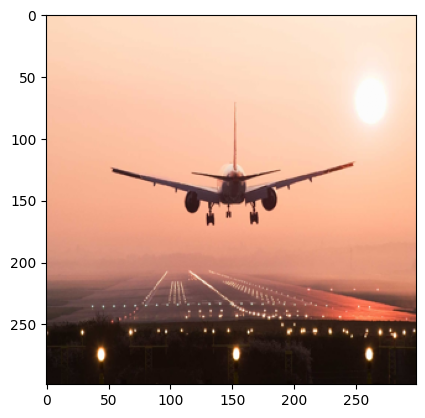

In [57]:
img_pil = Image.open('plane.jpg').convert('RGB')
img_resized = img_pil.resize((299, 299))  # (width, height)
img = np.array(img_resized).astype('float32') / 255.0

plt.imshow(img)

In [58]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a plane is flying on the runway .
a large airplane is flying in the air .
a plane is flying through a cloudy sky .
a plane is flying in the air
a large airplane is flying in the air .
a plane flying through the air on a runway .
a plane is parked in the air with a blue sky .
a plane is flying in the air .
a small airplane is flying in the sky .
a plane is flying in the air .


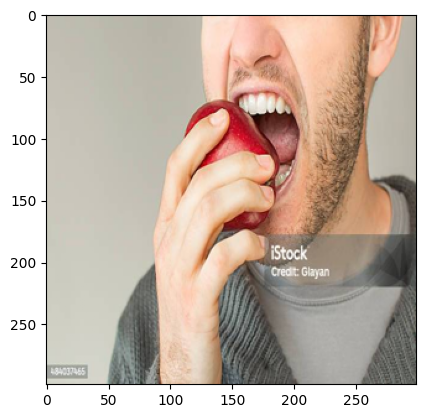

In [59]:
img_pil = Image.open('apple.jpg').convert('RGB')
img_resized = img_pil.resize((299, 299))  # (width, height)
img = np.array(img_resized).astype('float32') / 255.0

plt.imshow(img)

In [60]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man is holding a cell phone and a cell phone .
a man is holding a cell phone and a cell phone .
a man is holding a cell phone and a cell phone .
a man is holding a cell phone and a cell phone .
a man in a suit and a tie and a tie .
a man is holding a cell phone in the hand .
a man is holding a cell phone and a cell phone .
a man with a tie and a woman in a suit .
a man is holding a cell phone and a cell phone .
a man is holding a cell phone and a cell phone .


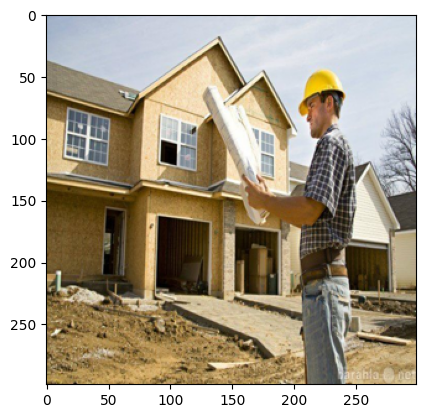

In [61]:
img_pil = Image.open('builder.jpg').convert('RGB')
img_resized = img_pil.resize((299, 299))  # (width, height)
img = np.array(img_resized).astype('float32') / 255.0

plt.imshow(img)

In [62]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man is standing in front of a building .
a man in a suit and a yellow shirt and a skateboard .
a man is standing on the side of a bench .
a man standing in front of a bench with a skateboard .
a man in a suit and a tie is holding a skateboard .
a man is standing in a park with a skateboard .
a man is standing in the middle of a park .
a man is standing in front of a building .
a man in a suit and a tie is standing in front of a building .
a man is standing in front of a building .


**Итог на своих изображениях** <br>
Модель легко распознает крупные объекты на картинке, например человек, собака, самолет. Со вторым планом дела обстоят похуже, особенно когда на картинке много объектов. Также можно отметить, что модель часто пытается "увидеть" человека на скейтборде.